*Exercise: Data Collection and Preparation: You have been provided with a full dataset of charging sessions
 in two sites for an extended timeframe. The first step should start by ingesting the data in appropriate
 format, checking for missing or erroneous data, and cleaning your dataset for use in later stages of
 your project. Briefly describe how you proceeded and how you dealt with possible missing/erroneous
 data.*
 
### **General Idea:**
To keep track of the operations we run on the data set and have an overview over the changes these operations make to our data or its structure, we employed a technique comparable to database or schema migration. The changes we made are partitioned into python scripts, which are, mostly out of the chronological order in which they were created, alphabetically sorted from A up. To obtain a fully processed data set with the processing itself being reproducable and controllable, we employed another script which runs all "migrations" in order and saves the final result as a cleaned .csv under data/processed.

### **What manipulations did we execute?**
A. to preserve the initial data set, it is copied at first.\
B. Five values in total had timestamps that yielded great implausible durations probably stemming from a *doneChargingTime* measurement error. These were removed.\
C. *doneChargingTime* caused these implausible durations in many more cases, but these only resulted in implausible timestamp offsets of < 1min. Handling consisted of setting *doneChargingTime* equal to *connectionTime* or *disconnectTime*, depending on the case. With these changes in place, the data set could be extended by the columns *duration* and *durationUntilFullCharge*\
CA. To remove outliers, we truncated the *duration* column at the 0.997 quantile.\
D. For easier interpretation, we changed these new columns' data types into floats, representing the number of hours.\
E. Next, we added ChargingPower (kW) by dividing *kWhDelivered* by *durationUntilFullCharge* or, if *null*, by *duration*. the resulting distribution shows that only 17 sessions have a charging power of over 50kW. As it is unlikely that the charging stations have an output of over 50 kW at all given this small number of corresponding calculations, these samples were identified as outliers and removed.\
F. To clean the set from data that does not increase relevant information, we truncated *spaceID*, since it holds a bijective relationship with *stationID*\

The data manipulations from H on are mostly task-specific and will be covered in the next tasks' notebooks. However, to have all manipulations cleanly and runnable in one place, they will be included in the code cell below. Note: operation G is deprecated.

### ***High-Level First Observations:***
To gain an overview of the entire data set, we use the *chargingPower* column, as it indicates the ratio of the essential columns *kwhDelivered* and *durationUntilFullCharge* or, if missing, *duration* and because this column does not contain any missing values. See the plot down below.

First, we note that there are times in which no measurements happened. From the beginning until September 2018, no measurements were taken on site 1, as opposed to site 2. Then, from April 2020 on, there were remarkably few sessions on each site, which may stem from the covid-19 epidemic. The epidemic might also be the cause of the next anomaly. Approximately from August until the end of November 2020, there were no sessions being recorded at all. After this intermission, from December on, recordings continue. For site 2, we can even observe some changes from this point in time. It seems as if the operator has put in place new chargers, being capable of charging with higher power than before. From December 202 until the end of the recordings in the next year's fall, we can regularly see charging power calculations rise to just below 50 kW.


In [60]:
import os
os.chdir(r'C:\Users\malte\PycharmProjects\AAEnergizer')
print(os.getcwd())  # Verify the new working directory

C:\Users\malte\PycharmProjects\AAEnergizer


In [62]:
#data operations
import pandas as pd
from sympy.printing.pretty.pretty_symbology import line_width


def A_copy_csv(from_path, to_path):
    pd.read_csv(from_path).to_csv(to_path, index=False)
    
    print("A: copied")
    
def B_remove_single_rows_with_implausible_timestamps(dataset_path):
    df = pd.read_csv(dataset_path)

    #remove rows with implausible timestamps of over 1 minute difference
    ids_to_be_removed = [
        '5c99728ff9af8b5022123831',    # disconnecttime < donechargingtime
        '5e7954b0f9af8b090600ec84',    # disconnecttime < donechargingtime
        '5c2e85daf9af8b13dab07564',    # donechargingtime < connectiontime
        '5c2e85daf9af8b13dab07565',    # donechargingtime < connectiontime
        '5c2e85daf9af8b13dab07566'     # donechargingtime < connectiontime
    ]

    #remove all rows from ids_to_be_removed from df
    df = df[~df['sessionID'].isin(ids_to_be_removed)]

    df.to_csv(dataset_path, index=False)
    
    print("B_: rows removed")

def C_add_durations_set_negatives_to_zero(dataset_path):

    dataFrame = pd.read_csv(dataset_path, parse_dates=["connectionTime", "disconnectTime", "doneChargingTime"])

    #set doneChargingTime = connectionTime when doneChargingTime < connectionTime (result -> durationUntilFullCharge = 0 when initially negative)
    dataFrame.loc[dataFrame["doneChargingTime"] < dataFrame["connectionTime"], "doneChargingTime"] = dataFrame["connectionTime"]

    # gibts glaub ich garnet...
    #set disconnectTime = connectionTime when disconnectTime < connectionTime (result -> duration = 0 when initially negative)
    dataFrame.loc[dataFrame["disconnectTime"] < dataFrame["connectionTime"], "disconnectTime"] = dataFrame["connectionTime"]

    #...dafür gibts aber disconnectTime < doneChargingTime
    # set disconnectTime = doneChargingTime when disconnectTime < doneChargingTime (result -> duration = 0 when initially negative)
    dataFrame.loc[dataFrame["disconnectTime"] < dataFrame["doneChargingTime"], "doneChargingTime"] = dataFrame["disconnectTime"]

    #add "duration" column: whole time span the EV is CONNECTED
    dataFrame["duration"] = (dataFrame["disconnectTime"] - dataFrame["connectionTime"])

    #add "doneChargingDuration" column: whole time span the EV is CHARGING
    dataFrame["durationUntilFullCharge"] = (dataFrame["doneChargingTime"] - dataFrame["connectionTime"])

    #save to csv
    dataFrame.to_csv(dataset_path, index=False)
    
    print("C_: durations added, small implausible offsets handled")

def D_turn_durations_into_floats_representing_hours(dataset_path):

    dataFrame = pd.read_csv(dataset_path, parse_dates=["connectionTime", "disconnectTime", "doneChargingTime"])

    dataFrame["duration"] = pd.to_timedelta(dataFrame["duration"])

    dataFrame["durationUntilFullCharge"] = pd.to_timedelta(dataFrame["durationUntilFullCharge"])

    #turn nano second data type into float representing hours
    dataFrame["durationUntilFullCharge"] = dataFrame["durationUntilFullCharge"].dt.total_seconds() / 3600
    dataFrame["duration"] = dataFrame["duration"].dt.total_seconds() / 3600

    #save to csv
    dataFrame.to_csv(dataset_path, index=False)
    
    print("D_: durations turned into floats representing hours")

def DA_remove_duration_outliers(dataset_path):
    dataFrame = pd.read_csv(dataset_path, parse_dates=["connectionTime", "disconnectTime", "doneChargingTime"])

    # Ensure 'duration' column is numeric
    dataFrame['duration'] = pd.to_numeric(dataFrame['duration'], errors='coerce')

    # .997th quantile is around 30h
    duration_threshhold = dataFrame['duration'].quantile(0.997)

    # Filter out rows where 'duration' exceeds the 0.997 quantile
    dataFrame = dataFrame[dataFrame['duration'] <= duration_threshhold]

    # save to csv
    dataFrame.to_csv(dataset_path, index=False)

    print("DA_: duration outliers removed")

def E_add_charging_power_remove_outliers(dataset_path):
    dataFrame = pd.read_csv(dataset_path, parse_dates=["connectionTime", "disconnectTime", "doneChargingTime"])

    # Add a new column chargingPower (Ladeleistung in kW)
    dataFrame["chargingPower"] = .0

    # Case 1: Calculate chargingPower where durationUntilFullCharge > 0
    mask_full_charge = dataFrame["durationUntilFullCharge"] > 0
    dataFrame.loc[mask_full_charge, "chargingPower"] = (
        dataFrame["kWhDelivered"] / dataFrame.loc[mask_full_charge, "durationUntilFullCharge"]
    )

    # Case 2: Calculate chargingPower using duration if doneChargingTime is null
    mask_null_done_charging = dataFrame["doneChargingTime"].isna()
    dataFrame.loc[mask_null_done_charging, "chargingPower"] = (
        dataFrame["kWhDelivered"] / dataFrame.loc[mask_null_done_charging, "duration"]
    )
    #handling, damit die Zeit in der nicht geladen wird nicht die Berechnung der Ladeleistung verfälscht

    ##############################################################################################################
    #remove outliers with chargingpower > 50kW
    ids_to_be_removed = [
        '5bc9297df9af8b0dc677c7cf',
        '61341051f9af8b434b144cd3',
        '60cd3a8ff9af8b228751eabf',
        '610c829df9af8b0580e9872c',
        '5dccae31f9af8b1ddbaaddf2',
        '610c829df9af8b0580e98731',
        '5be2fd24f9af8b2b0edfa126',
        '5bc918bff9af8b0dc677b99d',
        '5bc917d0f9af8b0dc677b8cf',
        '610c829df9af8b0580e9873f',
        '610c829df9af8b0580e9873e',
        '5df82ffbf9af8b399f100ec4',
        '5df82ffbf9af8b399f100ec5',
        '60cd3a8ff9af8b228751eac1',
        '61171011f9af8b160784513b',
        '5d35038df9af8b5eb4734d24',
        '610c829df9af8b0580e98737'
    ]

    # remove all rows from ids_to_be_removed from df
    dataFrame = dataFrame[~dataFrame['id'].isin(ids_to_be_removed)]

    ##############################################################################################################

    #save to csv
    dataFrame.to_csv(dataset_path, index=False)

    print("E_: Added chargingPower and removed outliers.")

def F_remove_spaceID(dataset_path):
    dataFrame = pd.read_csv(dataset_path, parse_dates=["connectionTime", "disconnectTime", "doneChargingTime"])

    # Remove column stationID
    dataFrame.drop(columns=["spaceID"], inplace=True)

    # Save to csv
    dataFrame.to_csv(dataset_path, index=False)
    
    print("F_: Removed spaceID column")

def H_create_nn_ds(dataset_path, weather_dataset_path, nn_dataset_path):

    def add_holidays(df):
        from pandas.tseries.holiday import USFederalHolidayCalendar
        df['hour'] = pd.to_datetime(df['hour'])
        df['date'] = df['hour'].dt.date
    
        cal = USFederalHolidayCalendar()
        holidays = cal.holidays(start=df['hour'].min(), end=df['hour'].max()).to_pydatetime()
        holiday_dates = set([d.date() for d in holidays])
    
        df['is_holiday'] = df['date'].apply(lambda x: 1 if x in holiday_dates else 0)
        df['is_weekend'] = df['hour'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
        df['is_vacation'] = df['hour'].dt.month.apply(lambda x: 1 if x in [6, 7, 8, 12] else 0)
    
        # verschiebe die zeilen holiday weekend und vac 24 stunden nach oben, da wir zukünftige werte vorhersagen wollen
        df['is_holiday'] = df['is_holiday'].shift(-24)
        df['is_weekend'] = df['is_weekend'].shift(-24)
        df['is_vacation'] = df['is_vacation'].shift(-24)
    
    
        def season(month):
            if month in [12, 1, 2]:
                return 'Winter'
            elif month in [3, 4, 5]:
                return 'Spring'
            elif month in [6, 7, 8]:
                return 'Summer'
            else:
                return 'Fall'
    
        df['season'] = df['hour'].dt.month.apply(season)
        df.drop(columns=['date'], inplace=True)
    
        return df
    
    df = pd.read_csv(dataset_path)
    weather_df = pd.read_csv(weather_dataset_path)

    df['connectionTime'] = pd.to_datetime(df['connectionTime'])
    df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
    df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])
    weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp']) - pd.Timedelta(hours=8)
    weather_df['hourly_timestamp'] = weather_df['timestamp'].dt.floor('h')

    ############# set disconnectTime where doneChargingTime is null #############
    df.loc[df['doneChargingTime'].isna(), 'doneChargingTime'] = df['disconnectTime']

    weather_df = weather_df.groupby('hourly_timestamp').agg({
        'temperature': 'mean',
        'precipitation': 'mean'
    }).interpolate(method='linear').reset_index()

    # Berechne alle Stunden im Zeitintervall
    time_intervals = pd.date_range(
        start=df['connectionTime'].min().floor('h'),
        end=df['disconnectTime'].max().ceil('h'),
        freq='h'
    )

    site_ids = df['siteID'].unique()
    hourly_data = []

    print("H_: Creation of time series data set: Calculation of hourly active sessions, charging sessions and charging power...")
    i=0
    for start_time in time_intervals:
        i += 1
        if i % 500 == 0:
            print(f"H_: Processed {i}/{len(time_intervals)} hours...")
        end_time = start_time + pd.Timedelta(hours=1)
        row = {'hour': start_time}

        for site_id in site_ids:
            # Filter für aktive Sessions
            site_df = df[df['siteID'] == site_id]
            active_sessions = site_df[
                (site_df['connectionTime'] < end_time) & (site_df['disconnectTime'] > start_time)
                ]

            charging_sessions = site_df[
                (site_df['connectionTime'] < end_time) & (site_df['doneChargingTime'] > start_time)
                ]

            avg_power = charging_sessions['chargingPower'].mean() if not charging_sessions.empty else 0
            charging_sessions_count = len(charging_sessions)
            active_session_count = len(active_sessions)

            row[f'avgChargingPower_site_{site_id}'] = avg_power
            row[f'chargingSessions_site_{site_id}'] = charging_sessions_count
            row[f'activeSessions_site_{site_id}'] = active_session_count

        hourly_data.append(row)

    hourly_df = pd.DataFrame(hourly_data)
    hourly_df['hour'] = hourly_df['hour'].dt.tz_localize(None)
    weather_df['hourly_timestamp'] = weather_df['hourly_timestamp'].dt.tz_localize(None)

    # Merging Wetterdaten
    hourly_df = pd.merge(hourly_df, weather_df, left_on='hour', right_on='hourly_timestamp', how='left')
    hourly_df.drop(columns=['hourly_timestamp'], inplace=True)

    # jetzt ist jede uhrzeit 2 mal da und es ist immer entweder die eine oder die andere siteID gefüllt, die andere ist null

    # Feiertage hinzufügen (falls implementiert)
    hourly_df = add_holidays(hourly_df)

    # Speichern der Ergebnisse
    hourly_df.to_csv(nn_dataset_path, index=False)
    print("H_: hourly data for prediction and aggregated visualization saved to ", nn_dataset_path)

    return hourly_df 

def HA_add_drawn_power_and_rates(nn_dataset_path, dataset_path):
    #session data set for retrieval of unique station ID counts
    session_data = pd.read_csv(dataset_path)

    #get the number of unique stationIDs for each siteID within session data
    site_1_total_stations = session_data[session_data['siteID'] == 1]['stationID'].nunique()
    site_2_total_stations = session_data[session_data['siteID'] == 2]['stationID'].nunique()

    df = pd.read_csv(nn_dataset_path)

    # Add 'total_drawn_power' columns
    df['total_drawn_power_1'] = df['chargingSessions_site_1'] * df['avgChargingPower_site_1']
    df['total_drawn_power_2'] = df['chargingSessions_site_2'] * df['avgChargingPower_site_2']

    # Add 'utilization_rate' columns
    df['utilization_rate_1'] = df['activeSessions_site_1'] / site_1_total_stations
    df['utilization_rate_2'] = df['activeSessions_site_2'] / site_2_total_stations

    # Add 'idle_rate' columns
    df['idle_rate_1'] = (df['activeSessions_site_1'] - df['chargingSessions_site_1']) / df['activeSessions_site_1']
    df['idle_rate_2'] = (df['activeSessions_site_2'] - df['chargingSessions_site_2']) / df['activeSessions_site_2']

    # Handle potential division by zero for idle_rate
    df['idle_rate_1'] = df['idle_rate_1'].fillna(0)  # If activeSessions_site_1 is 0
    df['idle_rate_2'] = df['idle_rate_2'].fillna(0)  # If activeSessions_site_2 is 0

    df.to_csv(nn_dataset_path, index=False)
    print("HA_: KPI columns added to the hourly data set and saved to ", nn_dataset_path)

    return df

def HB_add_avg_min_max_KPIs(nn_dataset_path, KPI_dataset_path):
    hourly_data = pd.read_csv(nn_dataset_path)

    #parse
    hourly_data['hour'] = pd.to_datetime(hourly_data['hour'])

    #to get full days going from 00:00:00 to 23:00:00
    hourly_data = hourly_data.iloc[13:-16]

    #relevant columns
    relevant_columns = [
        'utilization_rate_1', 'utilization_rate_2',
        'total_drawn_power_1', 'total_drawn_power_2',
        'idle_rate_1', 'idle_rate_2'
    ]

    #resample and calculate min, max, mean
    aggregated_data = (
        hourly_data
        .set_index('hour')
        .resample('24h')[relevant_columns]
        .agg(['min', 'max', 'mean'])
    )

    #build new column names
    aggregated_data.columns = [
        f"{col}_{stat}" for col, stat in aggregated_data.columns
    ]

    # Step 6: Reset index and rename time column to 'day'
    aggregated_data = aggregated_data.reset_index().rename(columns={'hour': 'day'})

    aggregated_data.to_csv(KPI_dataset_path, index=False)
    print("HB_: aggregated KPI dataset saved to ", KPI_dataset_path)

    return aggregated_data

def I_prepare_nn_ds(nn_dataset_path):
    
    import numpy as np
    
    def add_sin_cos_time_features(df):
        # Spalte 'hour' in datetime umwandeln
        df['hour'] = pd.to_datetime(df['hour'])
    
        # Stunde extrahieren
        df['hour_of_day'] = df['hour'].dt.hour
    
        # Sinus- und Kosinus-Transformation für die Stunden (tageszyklisch)
        df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
    
        return df
    
    
    def add_sin_cos_season_features(df):
        # Mapping der Jahreszeiten auf numerische Werte
        season_mapping = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}
        df['season_num'] = df['season'].map(season_mapping)
    
        # Sinus- und Kosinus-Transformation für die Jahreszeiten (zyklisch)
        df['season_sin'] = np.sin(2 * np.pi * df['season_num'] / 4)
        df['season_cos'] = np.cos(2 * np.pi * df['season_num'] / 4)
    
        return df
    
    # Ergänzte Funktion zur Interpolation von Wetterdaten
    def interpolate_weather_data(weather_df):
        # Sicherstellen, dass die 'hour'-Spalte als datetime interpretiert wird
        weather_df['hour'] = pd.to_datetime(weather_df['hour'])
    
        # Sortiere den DataFrame nach Zeitstempel
        weather_df = weather_df.sort_values(by='hour')
    
        # Lineare Interpolation für die Spalten 'temperature' und 'precipitation'
        weather_df[['temperature', 'precipitation']] = weather_df[['temperature', 'precipitation']].interpolate(
            method='linear', limit_direction='both'
        )
    
        return weather_df

    # Load the dataset
    df = pd.read_csv(nn_dataset_path)

    # Add sine and cosine transformations for time and season
    df = add_sin_cos_time_features(df)
    df = add_sin_cos_season_features(df)

    # Interpolate weather data
    df = interpolate_weather_data(df)


    # sort the columns Index(['hour', 'avgChargingPower', 'activeSessions', 'temperature',
    #        'precipitation', 'is_holiday', 'is_weekend', 'is_vacation', 'season',
    #        'hour_of_day', 'hour_sin', 'hour_cos', 'season_num', 'season_sin',
    #        'season_cos'],
    #       dtype='object')
    #df = df[['hour', 'temperature', 'precipitation', 'is_holiday', 'is_weekend',
    #         'is_vacation', 'season', 'hour_of_day', 'hour_sin', 'hour_cos',
    #         'season_num', 'season_sin', 'season_cos', 'avgChargingPower_site_1',
    #         'activeSessions_site_1', 'chargingSessions_site_1', 'avgChargingPower_site_2', 'activeSessions_site_2', 'chargingSessions_site_2']]

    # add the column 'day_of_week' to the dataframe, so monday is 0 and sunday is 6
    df['day_of_week'] = df['hour'].dt.dayofweek

    # Save the updated DataFrame back to CSV
    df.to_csv(nn_dataset_path, index=False)

    print("I_: Dataset preparation completed. saved to ", nn_dataset_path)
    
def Z_cut_ds(nn_dataset_path, start_date, end_date):
    # Lade den Datensatz
    dataset = pd.read_csv(nn_dataset_path)

    # Stelle sicher, dass die 'hour'-Spalte als Datetime erkannt wird
    dataset['hour'] = pd.to_datetime(dataset['hour'])

    # Filtere den Datensatz basierend auf Start- und Enddatum
    filtered_dataset = dataset[(dataset['hour'] >= start_date) & (dataset['hour'] <= end_date)]

    # save the filtered dataset as a new csv file with same name but ending with _cut
    filtered_dataset.to_csv(nn_dataset_path.replace('.csv', '_cut.csv'), index=False)

    print("Z_: Dataset cut completed. Saved to ", nn_dataset_path.replace('.csv', '_cut.csv'))

    return filtered_dataset


def preprocess_dataset(
        raw_dataset_path:str = "data/raw/charging_sessions.csv", 
        processed_dataset_path:str = "data/processed/charging_sessions_cleaned.csv",
        raw_weather_dataset_path = "data/raw/weather_burbank_airport.csv",
        nn_dataset_path = "data/processed/hourly_avg_power.csv",
        KPI_dataset_path = "data/processed/daily_avg_min_max_KPIs.csv"
):

    A_copy_csv(from_path=raw_dataset_path, to_path=processed_dataset_path)
    B_remove_single_rows_with_implausible_timestamps(dataset_path=processed_dataset_path)
    C_add_durations_set_negatives_to_zero(dataset_path=processed_dataset_path)
    D_turn_durations_into_floats_representing_hours(dataset_path=processed_dataset_path)
    DA_remove_duration_outliers(dataset_path=processed_dataset_path)
    E_add_charging_power_remove_outliers(dataset_path=processed_dataset_path)
    F_remove_spaceID(dataset_path=processed_dataset_path)
    
    H_create_nn_ds(dataset_path=processed_dataset_path,
                   weather_dataset_path=raw_weather_dataset_path,
                   nn_dataset_path=nn_dataset_path
                   )
    HA_add_drawn_power_and_rates(nn_dataset_path=nn_dataset_path,
                                 dataset_path=processed_dataset_path
                                 )
    
    HB_add_avg_min_max_KPIs(nn_dataset_path=nn_dataset_path,
                            KPI_dataset_path=KPI_dataset_path
                            )
    I_prepare_nn_ds(nn_dataset_path=nn_dataset_path)
    
    Z_cut_ds(nn_dataset_path=nn_dataset_path, start_date="2018-09-05", end_date="2020-03-01")
    
preprocess_dataset()

A: copied
B_: rows removed
C_: durations added, small implausible offsets handled
D_: durations turned into floats representing hours
DA_: duration outliers removed
E_: Added chargingPower and removed outliers.
F_: Removed spaceID column
H_: Creation of time series data set: Calculation of hourly active sessions, charging sessions and charging power...
H_: Processed 500/29717 hours...
H_: Processed 1000/29717 hours...
H_: Processed 1500/29717 hours...
H_: Processed 2000/29717 hours...
H_: Processed 2500/29717 hours...
H_: Processed 3000/29717 hours...
H_: Processed 3500/29717 hours...
H_: Processed 4000/29717 hours...
H_: Processed 4500/29717 hours...
H_: Processed 5000/29717 hours...
H_: Processed 5500/29717 hours...
H_: Processed 6000/29717 hours...
H_: Processed 6500/29717 hours...
H_: Processed 7000/29717 hours...
H_: Processed 7500/29717 hours...
H_: Processed 8000/29717 hours...
H_: Processed 8500/29717 hours...
H_: Processed 9000/29717 hours...
H_: Processed 9500/29717 hours...


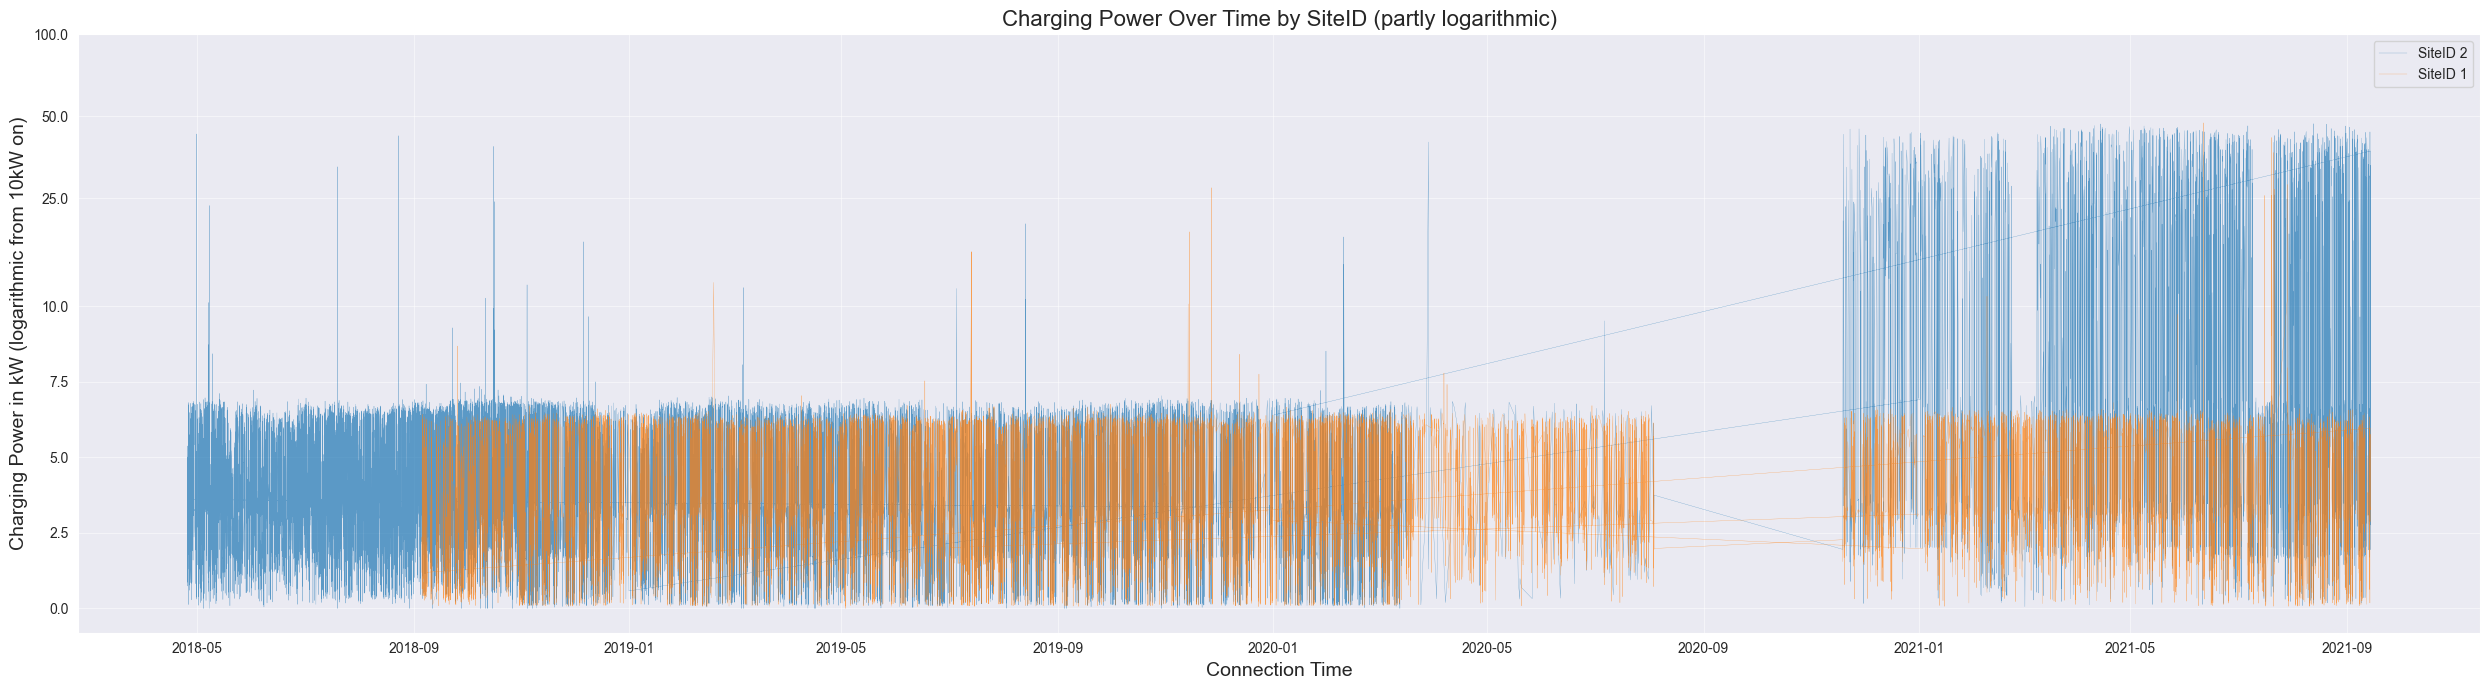

In [53]:
def plot_charging_power():
    from matplotlib import ticker
    import pandas as pd
    import matplotlib.pyplot as plt

    #load data
    df = pd.read_csv('../data/processed/charging_sessions_cleaned.csv')

    #parse dates
    df['connectionTime'] = pd.to_datetime(df['connectionTime'])
    df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
    df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])
    
    #split in siteID 1 and 2 using .loc
    df_site_1, df_site_2 = df.loc[df['siteID'] == 1], df.loc[df['siteID'] == 2]
    
    #plotting basis
    plt.figure(figsize=(25, 7))
    
    # Plot line for siteID 2
    plt.plot(df_site_2['connectionTime'], df_site_2['chargingPower'], label='SiteID 2', alpha=0.7, linewidth = .2)
    
    # Plot line for siteID 1
    plt.plot(df_site_1['connectionTime'], df_site_1['chargingPower'], label='SiteID 1', alpha=0.7, linewidth = .2)
    
    # Customize plot
    plt.title('Charging Power Over Time by SiteID (partly logarithmic)', fontsize=16)
    plt.xlabel('Connection Time', fontsize=14)
    plt.ylabel('Charging Power in kW (logarithmic from 10kW on)', fontsize=14)
    plt.yscale("symlog", linthresh=10)
    plt.yticks([0,2.5,5,7.5,10,25,50,100])
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.legend()
    plt.grid(alpha=0.5)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

plot_charging_power()